In [1]:
# Use LSTM to generate new time series data
# Temporary import. It will be removed in the final vserion
import os
import sys

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, Sequential
from pytagi import Normalizer

from examples.data_loader import TimeSeriesDataloader
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm

from itertools import count
import copy

In [2]:
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
# net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hq_hybrid_onlydisp14.pth')
# net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hqts1_hybrid_onlydisp2.pth')
# net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hqts3_hybrid.pth')
net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hqts4_hybrid_stdv03.pth')

# # HQ-TS2
# # # State-space models: for baseline hidden states
# phi_AA = 0.999
# Sigma_AR = 0.11453**2
# # phi_AR = 0.51824134
# phi_AR = 0.6496100633472297
# Sigma_AA = Sigma_AR*1e-16
# LA_var_stationary = Sigma_AA /(1-phi_AA**2)
# AR_var_stationary = Sigma_AR /(1-phi_AR**2)
# # Autoregressive acceleration + online AR
# # hybrid = LSTM_SSM(
# #     neural_network = net,           # LSTM
# #     baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
# #     zB  = np.array([0.1, 1E-4, 0, 0.5, 0.02]),    # initial mu for baseline hidden states
# #     SzB = np.array([1E-5, 1E-8, LA_var_stationary, 0.25, Sigma_AR]),    # var
# #     phi_AA = phi_AA,
# #     Sigma_AR = Sigma_AR,
# #     Sigma_AA = Sigma_AA,
# # )
# hybrid = LSTM_SSM(
#     neural_network = net,           # LSTM
#     baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
#     zB  = np.array([0.1, 1E-4, 0, 0.02]),    # initial mu for baseline hidden states
#     SzB = np.array([1E-5, 1E-8, LA_var_stationary, AR_var_stationary]),    # var
#     phi_AA = phi_AA,
#     phi_AR = phi_AR,
#     Sigma_AR = Sigma_AR,
#     Sigma_AA = Sigma_AA,
#     use_online_AR=False,
# )

# # HQ-TS1
# phi_AA = 0.999
# Sigma_AR = 0.1**2
# phi_AR = 0.8666692955420894
# Sigma_AA = Sigma_AR*1e-16
# LA_var_stationary = Sigma_AA /(1-phi_AA**2)
# AR_var_stationary = Sigma_AR /(1-phi_AR**2)
# hybrid = LSTM_SSM(
#     neural_network = net,           # LSTM
#     baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
#     zB  = np.array([-1.4, 0.002, 0, -0.0621]),    # initial mu for baseline hidden states
#     SzB = np.array([1E-5, 1E-8, LA_var_stationary, Sigma_AR]),    # var
#     phi_AA = phi_AA,
#     phi_AR = phi_AR,
#     Sigma_AR = Sigma_AR,
#     Sigma_AA = Sigma_AA,
#     use_online_AR = False,
# )

# # HQ-TS3
# phi_AA = 0.999
# Sigma_AR = 0.15**2
# phi_AR = 0.8786054659813236
# Sigma_AA = Sigma_AR*1e-16
# LA_var_stationary = Sigma_AA/(1-phi_AA**2)
# AR_var_stationary = Sigma_AR /(1-phi_AR**2)
# hybrid = LSTM_SSM(
#     neural_network = net,           # LSTM
#     baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
#     zB  = np.array([1.3874175044257202, -0.011353509128656347, 0, 0.05]),    # initial mu for baseline hidden states
#     SzB = np.array([1E-5, 1E-8, LA_var_stationary, Sigma_AR]),    # var
#     phi_AA = phi_AA,
#     phi_AR = phi_AR,
#     Sigma_AR = Sigma_AR,
#     Sigma_AA = Sigma_AA,
#     use_online_AR = False,
# )

# HQ-TS4
phi_AA = 0.999
# Sigma_AR = 0.3
# phi_AR = 0.296859199126937
Sigma_AR = 0.3**2
phi_AR = 0.42855678358077254
# Sigma_AR = 0.1
# phi_AR = 0.29249549033754774
# Sigma_AR = 0.2
# phi_AR = 0.25081641225448925
Sigma_AA = Sigma_AR*1e-16
LA_var_stationary = Sigma_AA/(1-phi_AA**2)
AR_var_stationary = Sigma_AR /(1-phi_AR**2)
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([0.03705011427027955, -0.0003539603053563322, 0, 0.05]),    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, Sigma_AR]),    # var
    phi_AA = phi_AA,
    phi_AR = phi_AR,
    Sigma_AR = Sigma_AR,
    Sigma_AA = Sigma_AA,
    use_online_AR = False,
)

In [3]:
# date_time_file="data/HQ/LGA007PIAP-E010_Y_train_datetime.csv"
# date_time_file="data/HQ/hq_ts1_train_datetime.csv"
date_time_file="data/HQ/hq_ts4_train_datetime.csv"

time_covariates = ['week_of_year']
# time_covariates = ['day_of_year']
train_dtl = TimeSeriesDataloader(
    # x_file="data/HQ/LGA007PIAP-E010_Y_train.csv",
    # x_file="data/HQ/hq_ts1_train.csv",
    x_file="data/HQ/hq_ts4_train.csv",
    date_time_file=date_time_file,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = time_covariates,  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)

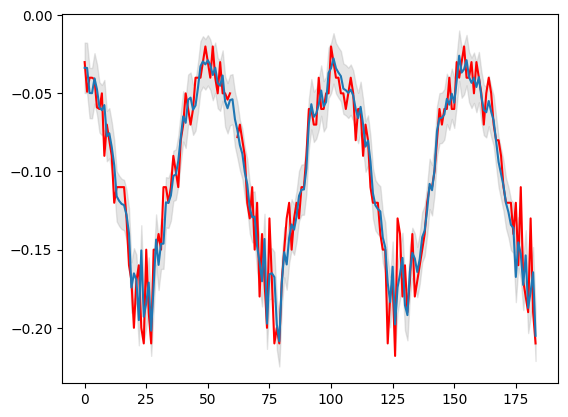

In [4]:
# Generate new time series data using the training set
for i in range(3):
    train_batch_iter = train_dtl.create_data_loader(batch_size=1, shuffle=False)

    mu_preds = []
    var_preds = []
    mu_preds_lstm = []
    var_preds_lstm = []
    obs_test_unnorm = []
    sigma_v = 1E-12
    batch_size = 1
    obs_norm = []
    hybrid.init_ssm_hs()
    var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)

    for x, y in train_batch_iter:
        x_input = np.copy(x)
        mu_x, var_x = process_input_ssm(
            mu_x = x_input, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
            input_seq_len = input_seq_len, num_features = num_features,)

        # Feed forward
        y_pred, Sy_red, z_prior, Sz_prior, m_pred, v_pred = hybrid(mu_x, var_x)
        hybrid.backward(mu_obs = y, var_obs = var_y)

        # obs = normalizer.unstandardize(
        #     y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        # )

        # y_pred_unnorm = normalizer.unstandardize(
        #     y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        # )

        mu_preds.extend(y_pred)
        var_preds.extend(Sy_red + sigma_v**2)
        mu_preds_lstm.extend(m_pred)
        var_preds_lstm.extend(v_pred)
        obs_norm.extend(y)

    mu_preds = np.array(mu_preds)
    std_preds = np.array(var_preds) ** 0.5
    obs_norm = np.array(obs_norm)
    obs_unnorm = normalizer.unstandardize(
        obs_norm, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
    )
    mu_preds = normalizer.unstandardize(
        mu_preds, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
    )
    std_preds = normalizer.unstandardize_std(std_preds, train_dtl.x_std[output_col])
    var_preds = std_preds ** 2

    hybrid.smoother()

# Keep the last 26 observation from the training set
last26_obs = obs_unnorm[-26:].tolist()

plt.figure()
plt.plot(obs_unnorm, color='r',label=r"obs.")
plt.plot(np.arange(len(obs_unnorm)), mu_preds, label='Prediction')
plt.fill_between(
    np.arange(len(obs_unnorm)),
    np.array(mu_preds).flatten() - np.sqrt(np.array(var_preds).flatten()),
    np.array(mu_preds).flatten() + np.sqrt(np.array(var_preds).flatten()),
    alpha=0.2,
    color='gray',
)

In [5]:
def normalize_date(date_time_i, mean, std):
    for time_cov in time_covariates:
        if time_cov == 'hour_of_day':
            hour_of_day = date_time_i.astype('datetime64[h]').astype(int) % 24
            output = hour_of_day
        elif time_cov == 'day_of_week':
            day_of_week = date_time_i.astype('datetime64[D]').astype(int) % 7
            output = day_of_week
        elif time_cov == 'week_of_year':
            week_of_year = date_time_i.astype('datetime64[W]').astype(int) % 52 + 1
            output = week_of_year
        elif time_cov == 'month_of_year':
            month_of_year = date_time_i.astype('datetime64[M]').astype(int) % 12 + 1
            output = month_of_year
        elif time_cov == 'quarter_of_year':
            month_of_year = date_time_i.astype('datetime64[M]').astype(int) % 12 + 1
            quarter_of_year = (month_of_year - 1) // 3 + 1
            output = quarter_of_year
        elif time_cov == 'day_of_year':
            day_of_year = date_time_i.astype('datetime64[D]').astype(int) % 365
            output = day_of_year

    output = Normalizer.standardize(data=output, mu=mean, std=std)
    return output

In [6]:
# Get mean and std from the original date time
date_time = pd.read_csv(date_time_file, skiprows=1, delimiter=",", header=None)
date_time = np.array(date_time, dtype='datetime64')
for time_cov in time_covariates:
    if time_cov == 'hour_of_day':
        hour_of_day = date_time.astype('datetime64[h]').astype(int) % 24
        output = hour_of_day
    elif time_cov == 'day_of_week':
        day_of_week = date_time.astype('datetime64[D]').astype(int) % 7
        output = day_of_week
    elif time_cov == 'week_of_year':
        week_of_year = date_time.astype('datetime64[W]').astype(int) % 52 + 1
        output = week_of_year
    elif time_cov == 'month_of_year':
        month_of_year = date_time.astype('datetime64[M]').astype(int) % 12 + 1
        output = month_of_year
    elif time_cov == 'quarter_of_year':
        month_of_year = date_time.astype('datetime64[M]').astype(int) % 12 + 1
        quarter_of_year = (month_of_year - 1) // 3 + 1
        output = quarter_of_year
    elif time_cov == 'day_of_year':
        day_of_year = date_time.astype('datetime64[D]').astype(int) % 365
        output = day_of_year
op_mean, op_std = Normalizer.compute_mean_std(output)
print(op_mean, op_std)

[26.37619048] [14.99004129]


In [7]:
date_time_train = copy.deepcopy(date_time)
x_train = copy.deepcopy(x)
mu_preds_lstm_train = copy.deepcopy(mu_preds_lstm)

In [8]:
print(date_time_train[-1])

['2015-02-08T12:00:00']


In [9]:
num_syn_ts = 200
syn_ts_len = 52*6
syn_ts_all = []

# Store the initial state of the hidden states
init_z = copy.deepcopy(hybrid.z)
init_Sz = copy.deepcopy(hybrid.Sz)

for j in tqdm(range(num_syn_ts)):
    # # Sample a model filename from models_filenames randomly
    # filename = np.random.choice(models_filenames)

    # # Replace the lstm network with the randomized one
    # net.load(filename=filename)
    # hybrid.net = net

    syn_ts_i=copy.deepcopy(last26_obs)
    date_time = copy.deepcopy(date_time_train)

    # Keep the last 26 datetime from the training set
    datetime_values_tosave = []
    for i in range(25):
        datetime_values_tosave.append(date_time[-(25-i)][0])
    current_date_time = date_time[-1] + np.timedelta64(7, 'D')
    datetime_values_tosave.append(current_date_time[0])

    AR_i = []
    x = copy.deepcopy(x_train)
    mu_preds_lstm = copy.deepcopy(mu_preds_lstm_train)

    hybrid.z = copy.deepcopy(init_z)
    hybrid.Sz = copy.deepcopy(init_Sz)

    for i in range(syn_ts_len):
        # remove the first two elements in x, and add two new at the end
        date_time = np.append(date_time, [date_time[-1] + np.timedelta64(7, 'D')]).reshape(-1, 1)
        # date_time = np.append(date_time, [date_time[-1] + np.timedelta64(1, 'D')]).reshape(-1, 1)
        next_date = normalize_date(date_time[-1], op_mean, op_std)
        x[0:-2] = x[2:]
        x[-2] = mu_preds_lstm[-1].item()
        x[-1] = next_date.item()

        x_input = np.copy(x)

        mu_x_, var_x_ = process_input_ssm(
                mu_x = x_input, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
                input_seq_len = input_seq_len, num_features = num_features,
                )
        # Feed forward
        y_pred, Sy_red, z_prior, Sz_prior, m_pred, v_pred = hybrid(mu_x_, var_x_)
        hybrid.backward(mu_obs = np.nan, var_obs = np.nan, train_LSTM=False)

        z_sample = np.random.multivariate_normal(z_prior.flatten(), Sz_prior)
        y = np.dot(hybrid.F, z_sample)

        # sample a y from y_pred, Sy_red using gaussian distribution
        # y = np.random.normal(y_pred, np.sqrt(Sy_red))[0]

        obs = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )

        # mu_preds.extend(y_pred)
        # var_preds.extend(Sy_red + sigma_v**2)
        mu_preds_lstm.extend(m_pred)
        var_preds_lstm.extend(v_pred)
        syn_ts_i.extend(obs)
        current_date_time = date_time[-1] + np.timedelta64(7, 'D')
        # current_date_time = date_time[-1] + np.timedelta64(1, 'D')
        datetime_values_tosave.append(current_date_time[0])
        AR_i.append(z_sample[-2])
        # obs_unnorm.extend(y)

    syn_ts_all.append(syn_ts_i)

100%|██████████| 200/200 [11:12<00:00,  3.36s/it]


In [10]:
print(train_dtl.x_mean, train_dtl.x_std)
print(init_z)

[-0.10050481 26.37619048] [ 0.0535239  14.99004129]
[[-1.56443140e-02]
 [-2.85164562e-04]
 [ 8.31091537e-10]
 [-1.48148374e-01]
 [-1.88193266e+00]]


In [11]:
print(len(datetime_values_tosave))
print(len(syn_ts_all[0]))

338
338


In [12]:
# Generate datetime
from datetime import datetime, timedelta
import csv

with open('syn_dataset_hqts4_lstm_datetime.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['date_time'])  # Write header
    for dt in datetime_values_tosave:
        writer.writerow([dt])  # Write formatted datetime string

In [13]:
transposed_data = list(zip(*syn_ts_all))
import csv

with open('syn_dataset_hqts4_lstm_unstandardized_model1_200episodes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(transposed_data)

/var/folders/vv/62ff9wx97g72zr4_20vx1q3h0000gn/T/ipykernel_98513/2106826567.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


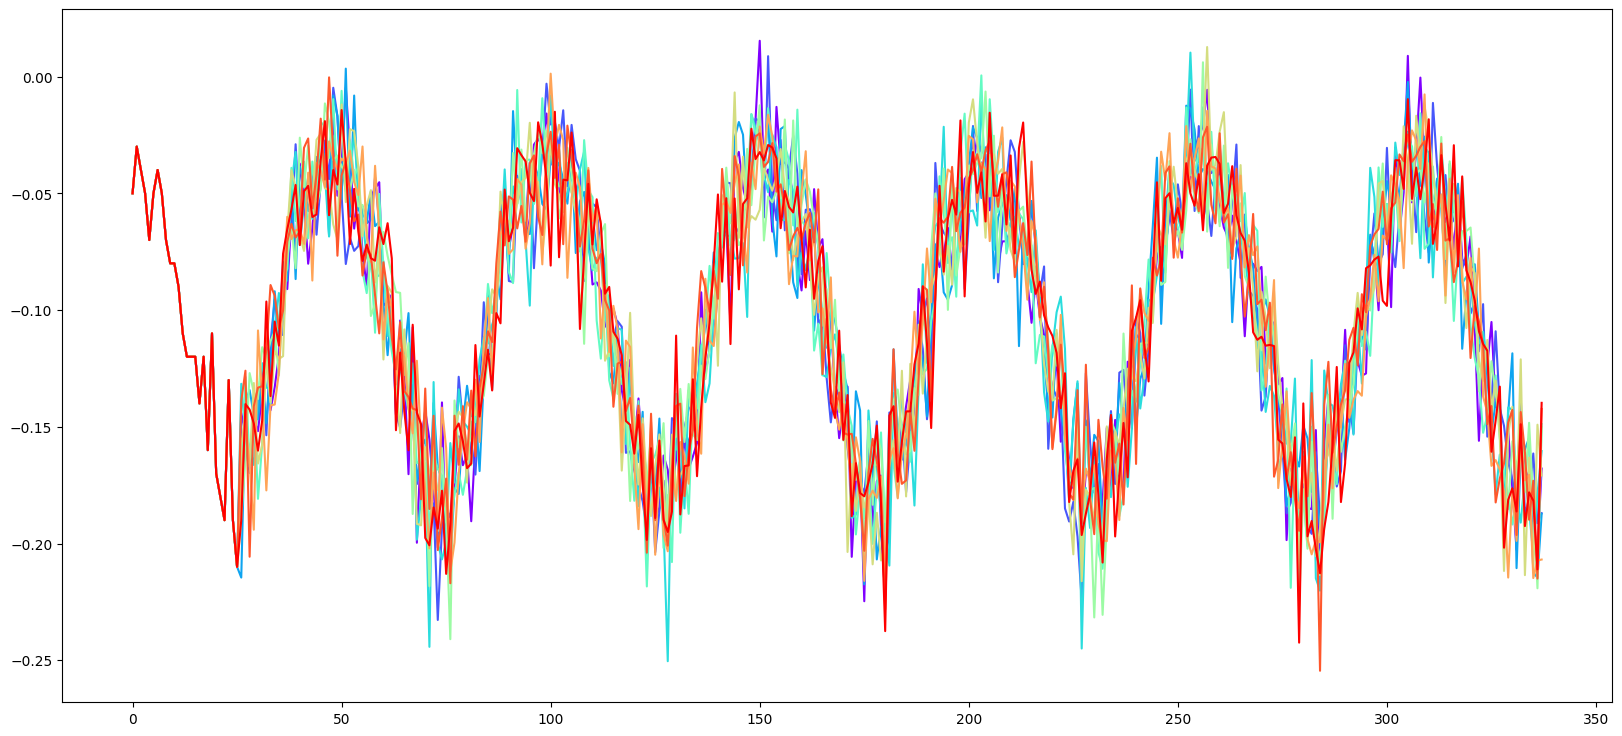

In [14]:
# Plot the first 10 time series in syn_ts_all
def get_cmap(n, name='rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

COLORS = get_cmap(10)
plt.figure(figsize=(20, 9))
for i in range(10):
    plt.plot(syn_ts_all[i], color = COLORS(i))
plt.show()

In [15]:
# # Save mu_ar and var_ar in a json file
# import json
# data = AR_i

# with open('saved_results/retrain_syn/true_AR.json', 'w') as outfile:
#     json.dump(data, outfile)

In [16]:
# # Generate datetime
# from datetime import datetime, timedelta
# import csv

# def generate_datetime_values(start_datetime, num_values):
#     datetime_values = []
#     current_datetime = start_datetime
#     for _ in range(num_values):
#         datetime_values.append(current_datetime)
#         current_datetime += timedelta(days=7)
#     return datetime_values

# with open('syn_dataset_hqts2_lstm_datetime_test.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['date_time'])  # Write header
#     start_datetime = datetime(2014, 3, 30, 12, 0, 0)  # Start datetime
#     datetime_values = generate_datetime_values(start_datetime, syn_ts_len)
#     for dt in datetime_values:
#         writer.writerow([dt.strftime('%Y-%m-%d %I:%M:%S')])  # Write formatted datetime string

In [17]:
# import csv

# column1 = []
# column2 = []

# with open('syn_dataset_hqts2_lstm.csv', 'r') as file:
#     reader = csv.reader(file)
#     for row in reader:
#         column1.append(float(row[0]))
#         column2.append(float(row[1]))

# print("Column 1:", column1)
# print("Column 2:", column2)

In [18]:
# plt.figure(figsize=(20, 9))
# plt.plot(syn_ts_i, color='r',label=r"obs.")
# # plt.plot(obs_unnorm, color='r',label=r"obs.")

# plt.plot(np.arange(len(mu_preds)), mu_preds, label='Prediction')
# plt.fill_between(
#     np.arange(len(mu_preds)),
#     np.array(mu_preds).flatten() - np.sqrt(np.array(var_preds).flatten()),
#     np.array(mu_preds).flatten() + np.sqrt(np.array(var_preds).flatten()),
#     alpha=0.2,
#     color='gray',
# )